In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization, Embedding, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [23]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [24]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [25]:
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data,y_data)

In [26]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [64]:
# # 重置数据维度
# print(x_train.shape)
# x_train = x_train.reshape(-1,1,x_train.shape[-1])
# x_test = x_test.reshape(-1,1,x_test.shape[-1])
# print(x_train.shape)

(1777, 2000)
(1777, 1, 2000)


In [27]:
# 对类别数据进行onehot编码
print(y_train.shape)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(y_train.shape)

(1777,)
(1777, 2)


In [28]:
# 构建网络
model = Sequential()
model.add(Embedding(input_dim=21, input_length=2000, output_dim=128))

model.add(Conv1D(128,16, activation='relu'))
model.add(Conv1D(128,8, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5))

model.add(Conv1D(64,16, activation='relu'))
model.add(Conv1D(64,8, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=2,strides=5))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu')))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 2000, 128)         2688      
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 1985, 128)         262272    
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 1978, 128)         131200    
_________________________________________________________________
batch_normalization_24 (Batc (None, 1978, 128)         512       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 395, 128)          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 380, 64)           131136    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 373, 64)         

In [29]:
# 训练网络
epochs = 100 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V6_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.8232 - accuracy: 0.5864
Epoch 00001: val_accuracy improved from -inf to 0.54831, saving model to BiLSTM_V6_1.h5
28/28 [==============================] - 109s 4s/step - loss: 0.8232 - accuracy: 0.5864 - val_loss: 0.6917 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.7819 - accuracy: 0.5926
Epoch 00002: val_accuracy did not improve from 0.54831
28/28 [==============================] - 104s 4s/step - loss: 0.7819 - accuracy: 0.5926 - val_loss: 0.7143 - val_accuracy: 0.4539 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.6140
Epoch 00003: val_accuracy did not improve from 0.54831
28/28 [==============================] - 98s 4s/step - loss: 0.7058 - accuracy: 0.6140 - val_loss: 0.8089 - val_accuracy: 0.4876 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0

28/28 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.7029
Epoch 00028: val_accuracy did not improve from 0.66067
28/28 [==============================] - 56s 2s/step - loss: 0.5627 - accuracy: 0.7029 - val_loss: 0.6986 - val_accuracy: 0.5708 - lr: 5.0000e-04
Epoch 29/100
28/28 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7175
Epoch 00029: val_accuracy did not improve from 0.66067
28/28 [==============================] - 60s 2s/step - loss: 0.5574 - accuracy: 0.7175 - val_loss: 0.7224 - val_accuracy: 0.5640 - lr: 5.0000e-04
Epoch 30/100
28/28 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.7271
Epoch 00030: val_accuracy did not improve from 0.66067
28/28 [==============================] - 56s 2s/step - loss: 0.5520 - accuracy: 0.7271 - val_loss: 0.7209 - val_accuracy: 0.5708 - lr: 5.0000e-04
Epoch 31/100
28/28 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.7333
Epoch 00031: val_accuracy 

Epoch 56/100
28/28 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.7327
Epoch 00056: val_accuracy did not improve from 0.66067
28/28 [==============================] - 75s 3s/step - loss: 0.5366 - accuracy: 0.7327 - val_loss: 0.7331 - val_accuracy: 0.5708 - lr: 2.5000e-04
Epoch 57/100
28/28 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7321
Epoch 00057: val_accuracy did not improve from 0.66067
28/28 [==============================] - 81s 3s/step - loss: 0.5425 - accuracy: 0.7321 - val_loss: 0.7354 - val_accuracy: 0.5820 - lr: 2.5000e-04
Epoch 58/100
28/28 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.7276
Epoch 00058: val_accuracy did not improve from 0.66067
28/28 [==============================] - 80s 3s/step - loss: 0.5369 - accuracy: 0.7276 - val_loss: 0.7514 - val_accuracy: 0.5820 - lr: 2.5000e-04
Epoch 59/100
28/28 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7327
Epoch 00059: 

Epoch 84/100
28/28 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.7333
Epoch 00084: val_accuracy did not improve from 0.67191
28/28 [==============================] - 59s 2s/step - loss: 0.5376 - accuracy: 0.7333 - val_loss: 0.7236 - val_accuracy: 0.5933 - lr: 2.5000e-04
Epoch 85/100
28/28 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7400
Epoch 00085: val_accuracy did not improve from 0.67191

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
28/28 [==============================] - 55s 2s/step - loss: 0.5451 - accuracy: 0.7400 - val_loss: 0.7294 - val_accuracy: 0.5910 - lr: 2.5000e-04
Epoch 86/100
28/28 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7383
Epoch 00086: val_accuracy did not improve from 0.67191
28/28 [==============================] - 58s 2s/step - loss: 0.5275 - accuracy: 0.7383 - val_loss: 0.7250 - val_accuracy: 0.6067 - lr: 1.2500e-04
Epoch 87/100
28/28 [========

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


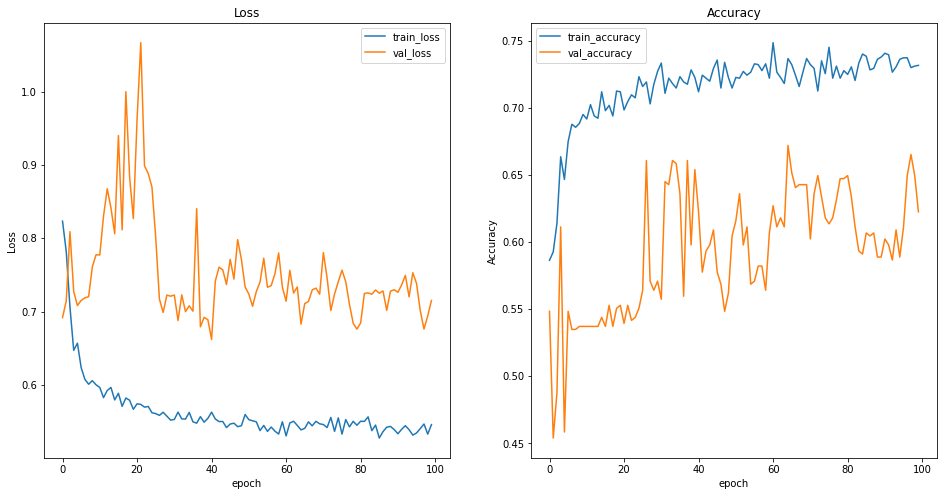

In [30]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [31]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V6_1.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [32]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 0.646% 召回率: 0.8520642201834863, f1: 0.7026004728132389
在20%测试集上, accuracy: 0.6719% 召回率: 0.8368200836820083, f1: 0.7326007326007327


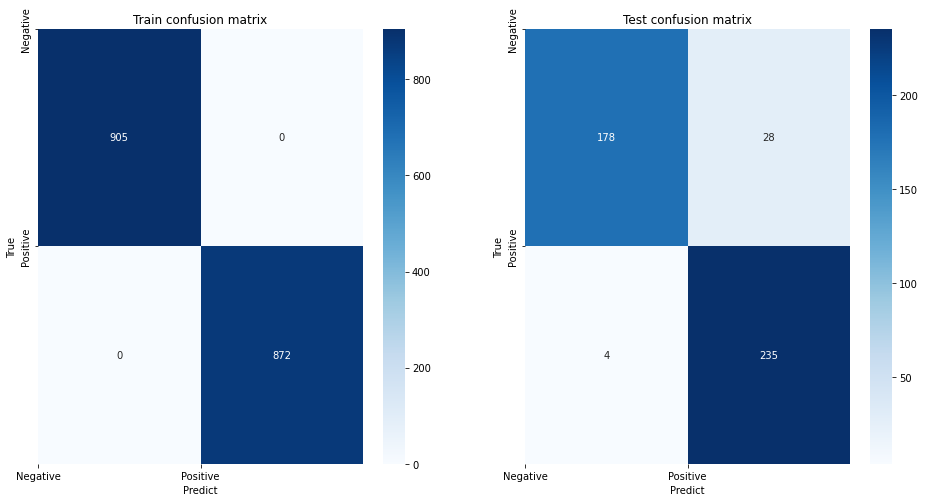

In [66]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()